In [8]:
import pandas as pd
pd.set_option('display.max_rows', 1000)

# Enter the data for your analysis - control strain results and results for the transformants - if you're analysing more then one construct, copy the empty datafremes for 
# cassettes = [control, CCW12....]

cassette = 

initial_data = pd.DataFrame({'cassette': [], 
                     'timepoint': [], 
                     'clone': [],
                     'growth': [],
                     'r-Prot': []})


blank_data = initial_data[initial_data['clone'] == 'control-']
data = pd.merge(initial_data, blank_data, on='timepoint', how='outer')
data.drop(columns=['cassette_y', 'clone_y', 'growth_y'], inplace=True)
data.rename(columns={'cassette_x':'cassette', 'clone_x':'clone', 'growth_x': 'growth'}, inplace=True)


data['activity_normalized [mL/h]'] = (data['r-Prot_x'] - data['r-Prot_y']) / 0.0143 / 2 * 1000/30
data['activity [umol/L/h]'] = data['activity_normalized [mL/h]'] /180.156 * 1000

print(data)


data['normalized_r-Prot'] = data['activity [umol/L/h]'] / data['growth']


data.loc[data['timepoint'] == 0, 'normalized_r-Prot'] = 0


            cassette  timepoint     clone  growth  r-Prot_x  r-Prot_y  \
0    scTlG-empty_leu          0         1   0.000    0.0000    0.0000   
1    scTlG-empty_leu          0         1   0.000    0.0000    0.0000   
2    scTlG-empty_leu          0         1   0.000    0.0000    0.0000   
3    scTlG-empty_leu          0         1   0.000    0.0000    0.0000   
4    scTlG-empty_leu          0         3   0.000    0.0000    0.0000   
5    scTlG-empty_leu          0         3   0.000    0.0000    0.0000   
6    scTlG-empty_leu          0         3   0.000    0.0000    0.0000   
7    scTlG-empty_leu          0         3   0.000    0.0000    0.0000   
8    scTlG-empty_leu          0         5   0.000    0.0000    0.0000   
9    scTlG-empty_leu          0         5   0.000    0.0000    0.0000   
10   scTlG-empty_leu          0         5   0.000    0.0000    0.0000   
11   scTlG-empty_leu          0         5   0.000    0.0000    0.0000   
12         scTlG-Gzf          0         1   0.000  

In [9]:
import kmeans1d
from statistics import mode

def cluster_and_mode(data, feature):
    list_data_feature = list(data[feature])
    clusters, _ = kmeans1d.cluster(list_data_feature, k=3)
    data[f'{feature}_clusters'] = clusters

    mode_cluster = mode(clusters)
    mode_clusters = data[data[f'{feature}_clusters'] == mode_cluster]
    return mode_clusters

features = ['growth', 'activity [umol/L/h]', 'normalized_r-Prot']
timepoints = data['timepoint'].unique()


# Accumulate common clones for each feature and timepoint
common_clones_accumulated = {}
for feature in features:
    for timepoint in timepoints:
        subset = data[(data['cassette'] == cassette) & (data['timepoint'] == timepoint)][['clone', feature]]
        clusters_mode = cluster_and_mode(subset, feature)
        current_clones = set(clusters_mode['clone'])
        print(f"Feature: {feature}, Timepoint: {timepoint}, Common Clones: {current_clones}")

        if (feature, timepoint) not in common_clones_accumulated:
            common_clones_accumulated[(feature, timepoint)] = current_clones
        else:
            common_clones_accumulated[(feature, timepoint)].intersection_update(current_clones)

# Perform intersection for all feature and timepoint combinations
common_clones = set.intersection(*common_clones_accumulated.values())



# Define the order of subsets to exclude
subset_order = ['growth', 'activity [umol/L/h]', 'normalized_r-Prot']

deleted_subsets = []

# Check if at least 3 common clones are found
while len(common_clones) < 1 and common_clones_accumulated:
    # Sort subsets by timepoint in ascending order
    sorted_subsets = sorted(common_clones_accumulated.keys(), key=lambda x: (x[1], subset_order.index(x[0])))

    # Iterate over sorted subsets
    for subset in sorted_subsets:
        # Exclude the current subset
        deleted_subsets.append(subset)
        del common_clones_accumulated[subset]

        # Recalculate common clones
        common_clones = set.intersection(*common_clones_accumulated.values())

        # Check if at least 3 common clones are found
        if len(common_clones) >= 3:
            break

# Print the final result

print("Deleted Subsets:", deleted_subsets)

Feature: growth, Timepoint: 0, Common Clones: {'8', '2', '6', 'control-', '4', '9', '3', '10', '1', '5', '7'}
Feature: growth, Timepoint: 26, Common Clones: {'8', '2', '6', '9', '4', '3', '5'}
Feature: growth, Timepoint: 48, Common Clones: {'6', 'control-', '4', '9', '5', '10', '7'}
Feature: activity [umol/L/h], Timepoint: 0, Common Clones: {'8', '2', '6', 'control-', '4', '9', '3', '10', '1', '5', '7'}
Feature: activity [umol/L/h], Timepoint: 26, Common Clones: {'8', '2', '6', '4', '9', '3', '10', '1', '5', '7'}
Feature: activity [umol/L/h], Timepoint: 48, Common Clones: {'8', '2', '6', '4', '9', '3', '5', '10', '7'}
Feature: normalized_r-Prot, Timepoint: 0, Common Clones: {'8', '2', '6', 'control-', '4', '9', '3', '10', '1', '5', '7'}
Feature: normalized_r-Prot, Timepoint: 26, Common Clones: {'8', '2', '6', '4', '9', '3', '10', '1', '5', '7'}
Feature: normalized_r-Prot, Timepoint: 48, Common Clones: {'8', '2', '6', '4', '9', '3', '5', '10', '7'}
Deleted Subsets: []


In [10]:
import numpy as np
pd.set_option('display.max_columns', 1000)

data_stat = data.groupby(['cassette', 'timepoint', 'clone']).agg(
    {'growth': ['mean', 'std'], 'activity [umol/L/h]': ['mean', 'std'], 'normalized_r-Prot': ['mean', 'std']}).reset_index()
data_stat.fillna(0, inplace=True)


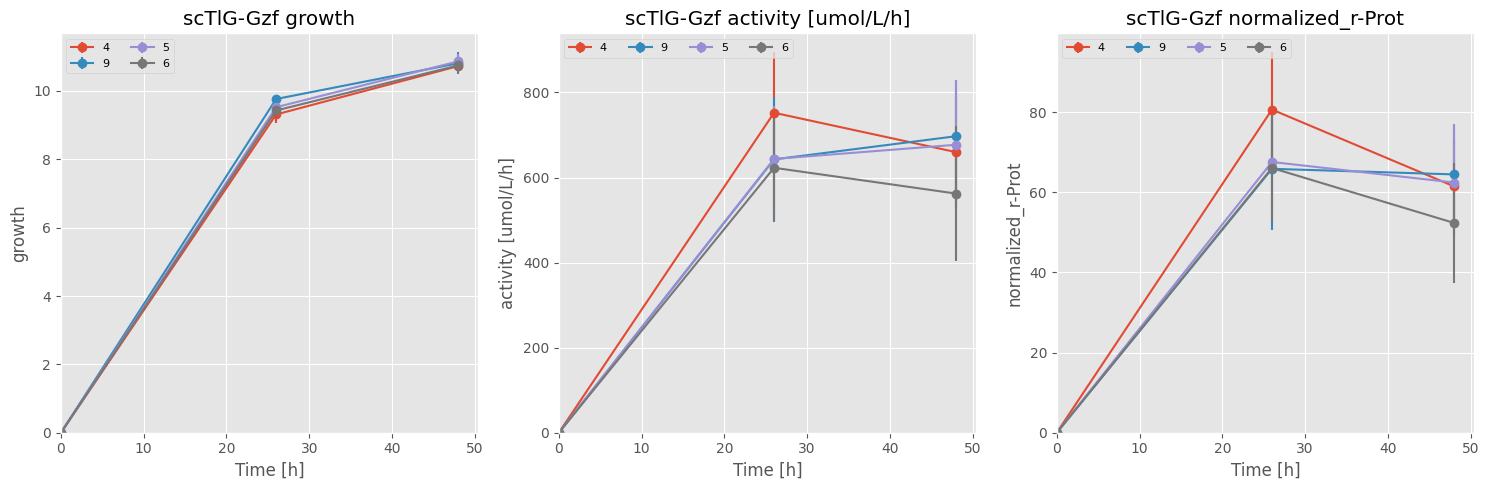

In [11]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

plt.style.use('ggplot')

# 3x subplot - growth, total r-Prot, normalized r-Prot
plt.figure(figsize=(15, 5))

chosen_clones = common_clones

for i, data_type in enumerate(['growth', 'activity [umol/L/h]', 'normalized_r-Prot'], start=1):
    plt.subplot(1, 3, i)

    for clone in chosen_clones:
        clone_data = data_stat[(data_stat['clone'] == clone) & (data_stat['cassette'] == cassette)]
        mean_values = clone_data[data_type, 'mean']
        std_values = clone_data[data_type, 'std']

        plt.errorbar(clone_data['timepoint'], mean_values, yerr=std_values, label=clone, marker='o', 
                         linestyle='-', linewidth=1.5)

    plt.title(f'{cassette} {data_type}')
    plt.xlabel('Time [h]')
    plt.ylabel(f'{data_type}')
    plt.xlim(0,)
    plt.ylim(0,)
    plt.legend(ncol=2 if i == 1 else 5, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(f'chosen_{cassette}.png')
plt.show()

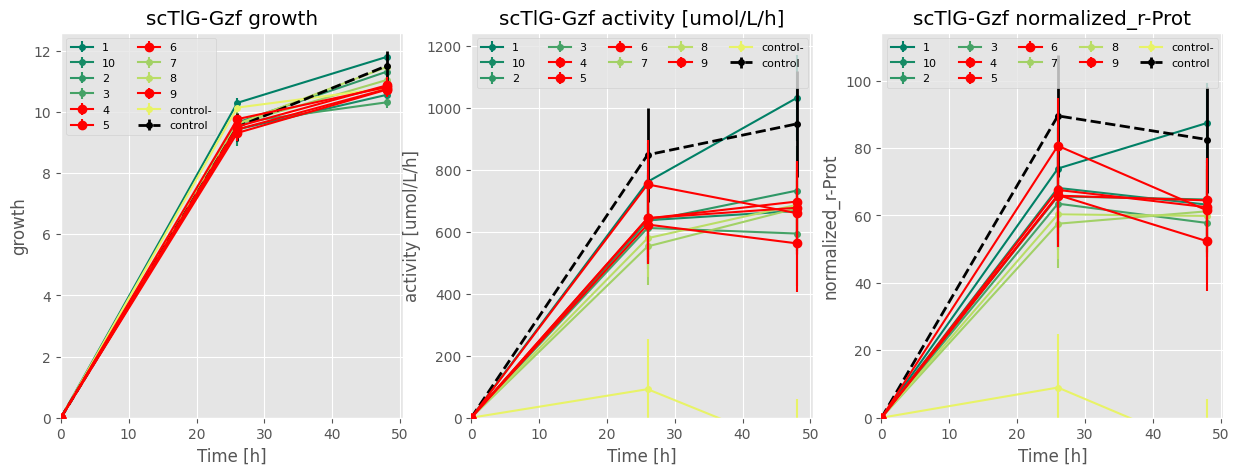

In [12]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

plt.style.use('ggplot')

# 3x subplot - growth, total r-Prot, normalized r-Prot
plt.figure(figsize=(15, 5))

colormap = plt.colormaps['summer']
normalize = plt.Normalize(vmin=0, vmax=len(data_stat['clone'].unique()) - 1)
scalar_map = ScalarMappable(cmap=colormap, norm=normalize)

chosen_clones = common_clones

for i, data_type in enumerate(['growth', 'activity [umol/L/h]', 'normalized_r-Prot'], start=1):
    plt.subplot(1, 3, i)

    for j, clone in enumerate(data_stat['clone'].unique()):
        clone_data = data_stat[(data_stat['clone'] == clone) & (data_stat['cassette'].isin([cassette, 'scTlG_control']))]
        mean_values = clone_data[data_type, 'mean']
        std_values = clone_data[data_type, 'std']

        if clone == 'control':
            plt.errorbar(clone_data['timepoint'], mean_values, yerr=std_values, label=clone, marker='o', markersize = 4, 
                         linestyle='--', color='black', linewidth=2, zorder = 2)
        elif clone in chosen_clones:
            plt.errorbar(clone_data['timepoint'], mean_values, yerr=std_values, label=clone, marker='o', 
                         linestyle='-', color='red', linewidth=1.5, zorder = 3)
        else:
            color = colormap(normalize(j))
            plt.errorbar(clone_data['timepoint'], mean_values, yerr=std_values, label=clone, marker='o', markersize = 4, 
                         linestyle='-', color=color, zorder = 1)

    plt.title(f'{cassette} {data_type}')
    plt.xlabel('Time [h]')
    plt.ylabel(f'{data_type}')
    plt.xlim(0,)
    plt.ylim(0,)
    plt.legend(ncol=2 if i == 1 else 5, loc='upper left', fontsize=8)

plt.savefig(f'{cassette}.png')
plt.show()


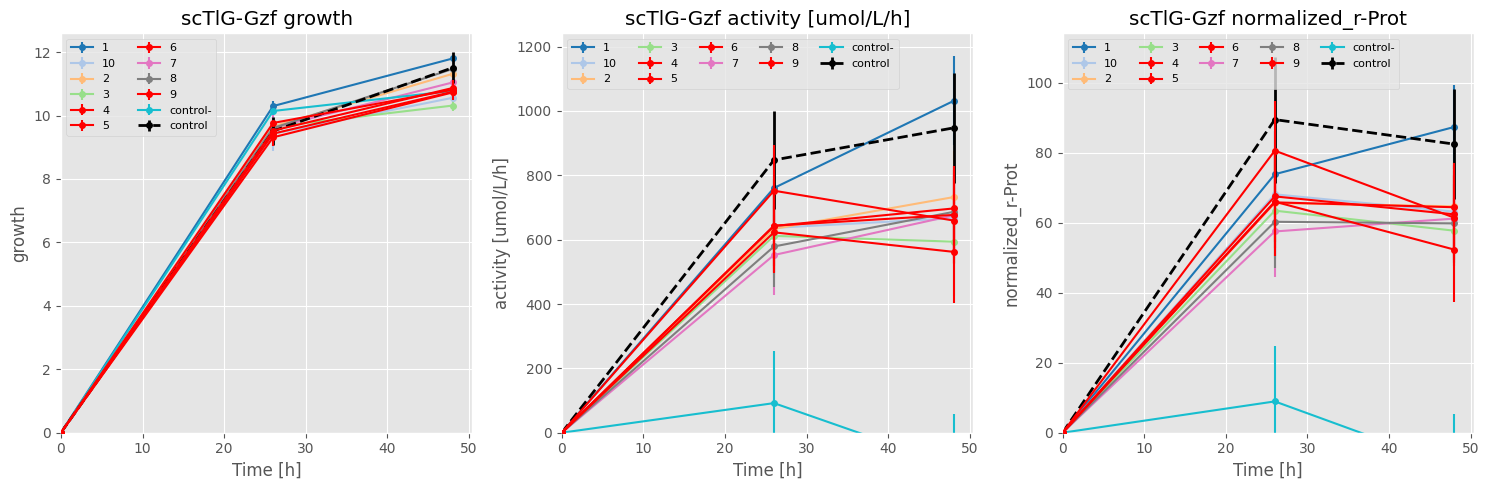

In [13]:

plt.style.use('ggplot')

# 3x subplot - growth, total r-Prot, normalized r-Prot
plt.figure(figsize=(15, 5))


chosen_clones = common_clones

for i, data_type in enumerate(['growth', 'activity [umol/L/h]', 'normalized_r-Prot'], start=1):
    plt.subplot(1, 3, i)

    for j, clone in enumerate(data_stat['clone'].unique()):
        clone_data = data_stat[(data_stat['clone'] == clone) & (data_stat['cassette'].isin([cassette, 'scTlG_control']))]
        mean_values = clone_data[data_type, 'mean']
        std_values = clone_data[data_type, 'std']

        if clone == 'control':
            plt.errorbar(clone_data['timepoint'], mean_values, yerr=std_values, label=clone, marker='o', markersize = 4, 
                         linestyle='--', color='black', linewidth=2, zorder = 2)
        else:
            color = plt.cm.tab20(normalize(j))
            plt.errorbar(clone_data['timepoint'], mean_values, yerr=std_values, label=clone, marker='o', markersize=4,
                 linestyle='-', color=color, zorder=1)

    plt.title(f'{cassette} {data_type}')
    plt.xlabel('Time [h]')
    plt.ylabel(f'{data_type}')
    plt.xlim(0,)
    plt.ylim(0,)
    plt.legend(ncol=2 if i == 1 else 5, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(f'{cassette}2.png')
plt.show()
